## Load dataset

In [2]:
import scanpy as sc
import scvelo as scv

data = scv.datasets.pancreas(file_path='/Users/evanli/Documents/Research_datasets/endocrinogenesis_day15.h5ad')
label = data.obs['clusters'].tolist()

In [3]:
import os
os.chdir('/Users/evanli/Documents/EvanPys/Progress/')

from ADlasso2 import AD2_w_utils as ad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [4]:
data.shape

(3696, 27998)

In [25]:
# Count each cell types
from collections import Counter

print(Counter(label))

Counter({'Ductal': 916, 'Ngn3 high EP': 642, 'Pre-endocrine': 592, 'Beta': 591, 'Alpha': 481, 'Ngn3 low EP': 262, 'Epsilon': 142, 'Delta': 70})


In [26]:
list(set(label))

['Ductal',
 'Ngn3 high EP',
 'Ngn3 low EP',
 'Epsilon',
 'Beta',
 'Delta',
 'Pre-endocrine',
 'Alpha']

## Normalization

In [27]:
# CPM (do not do CPM normalization)
# sc.pp.normalize_total(data, target_sum=1e6)

# log1p: log(x+1)
sc.pp.log1p(data)

In [28]:
# Finding features for a celltype
celltype = 'Delta'

# Binary classification of a celltype
celltype_label = [1 if x == celltype else 0 for x in label]

# create index for a celltype
celltype_indices = [idx for idx, label in enumerate(celltype_label) if label == 1]


## Lambda tuning

In [1]:
from ADlasso2 import AD2_w_utils as ad
importlib.reload(ad)


ModuleNotFoundError: No module named 'ADlasso2'

In [ ]:
# a list of lambdas to test
log_lmbd_range = np.linspace(np.log(1e-4), np.log(1), 25)
lmbd_range = np.exp(log_lmbd_range)
print(lmbd_range)

In [ ]:
result_dict = ad.lambda_tuning_evan(data.X, celltype_label, lmbd_range)

In [ ]:
result_dict

In [ ]:
os.chdir('./Pancreas_result/alpha a=1e-2/')

In [ ]:
# Export result dict as a file
import json

output = dict()
for key in result_dict.keys():
    output[key] = result_dict[key].tolist()

with open('{}_tuning.json'.format(celltype), 'w') as f:
    json.dump(output, f)
    

In [5]:
# Read result dict from json
import json
with open('/Users/evanli/Documents/EvanPys/Progress/Pancreas_ADlasso/Pancreas_result/Delta/Delta_tuning.json', 'r') as f:
    result_dict = json.load(f)

for key in result_dict.keys():
    if isinstance(result_dict[key], list):
        result_dict[key] = np.array(result_dict[key])
result_dict

{'Percentage': array([3.60132867e-01, 3.54096721e-01, 3.43988856e-01, 3.30452175e-01,
        1.57154082e-03, 1.35723980e-03, 1.10722194e-03, 8.92920923e-04,
        1.07150511e-03, 7.85770412e-04, 6.42903065e-04, 4.64318880e-04,
        4.28602043e-04, 3.57168369e-04, 4.28602043e-04, 1.78584185e-04,
        1.78584185e-04, 3.57168369e-04, 2.82163012e-03, 1.07150511e-04,
        7.14336738e-05, 7.14336738e-05, 1.78584185e-04, 0.00000000e+00,
        1.42867348e-04]),
 'Prevalence': array([0.12857143, 0.12857143, 0.14285714, 0.14285714, 1.        ,
        0.97857143, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.        , 1.        ]),
 'Train_prevalence': array([0.14285714, 0.13207547, 0.14035088, 0.15      , 1.        ,
        0.98113208, 1.        , 1.        , 1.        , 1.        ,
        1.      

## Visualization

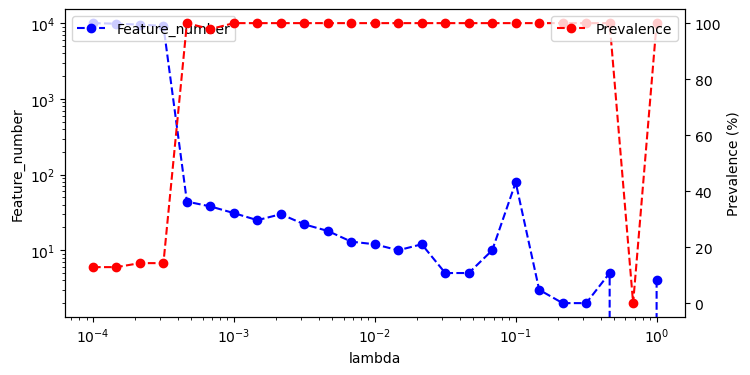

In [33]:
Fig = ad.lambda_tuning_viz(result_dict, 'Feature_number', savepath='{}_feature_number.png'.format(celltype))

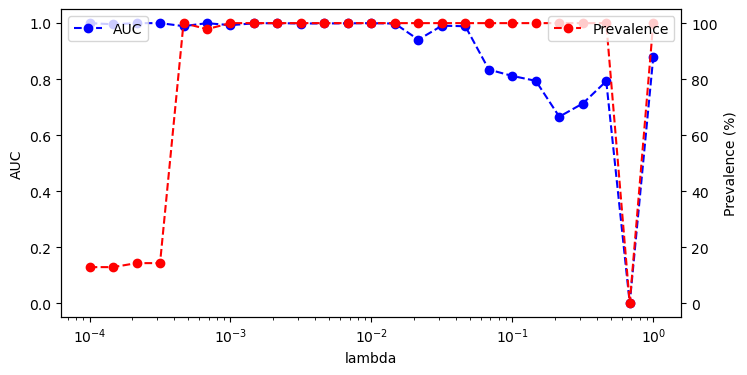

In [34]:
Fig = ad.lambda_tuning_viz(result_dict, 'AUC', savepath='{}_AUC.png'.format(celltype))

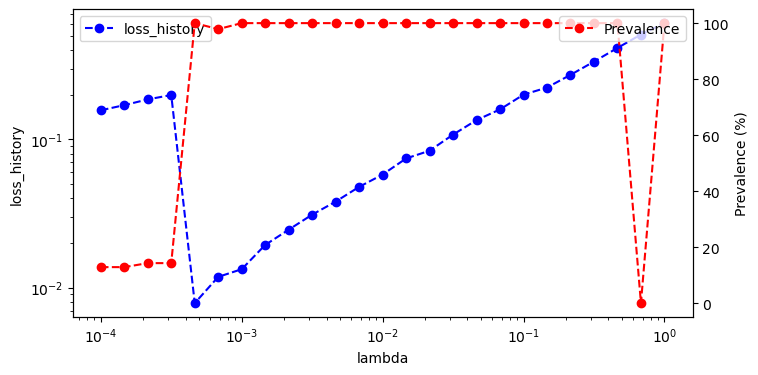

In [32]:
Fig = ad.lambda_tuning_viz(result_dict, 'loss_history')

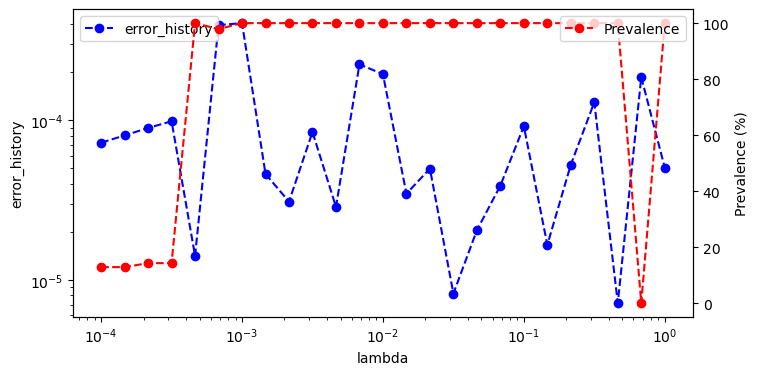

In [35]:
Fig = ad.lambda_tuning_viz(result_dict, 'error_history')

## Lambda decision
Determine the optimal lambda value based on the inflection point of the BCE loss curve

0.146779926762207

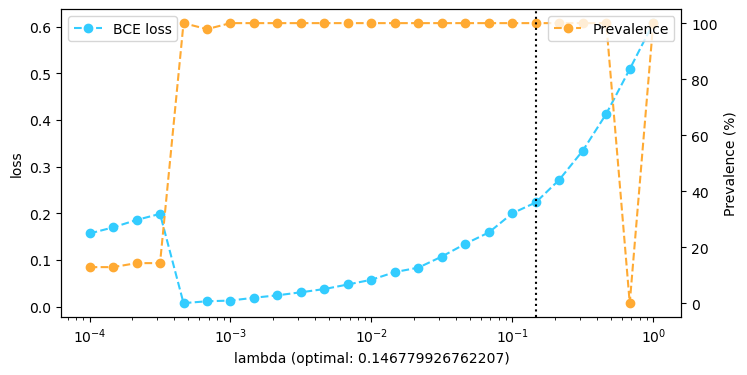

In [6]:
# NEW: lambda decision without y-axis log scale
# k: Decide n_segments to divide
opt_lmbd, fig = ad.lambda_decision(result_dict, k=2)
opt_lmbd

0.0004641588833612784

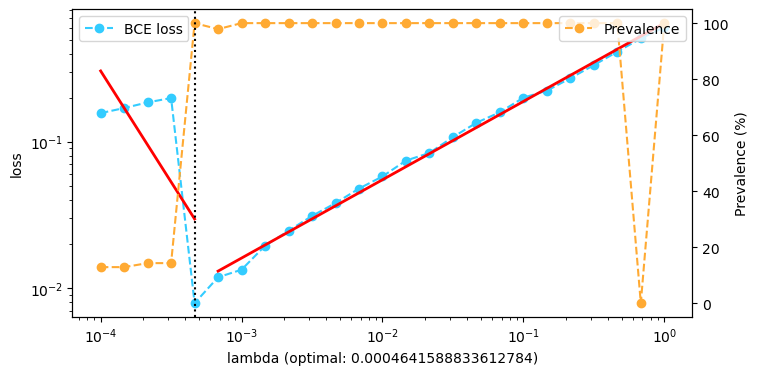

In [ ]:
# k: Decide n_segments to divide
opt_lmbd, fig = ad.lambda_decision(result_dict, k=2)
opt_lmbd

## Find marker genes with optimal lambda

In [37]:
pvl = ad.get_prevalence(data.X, celltype_indices)
opt_res = ad.ADlasso2(lmbd=opt_lmbd, echo=True)
opt_res.fit(data.X, celltype_label, pvl)

Getting prevalance
Fitting ADlasso2
QWL-QN convergence
QWL-QN convergence
minimum epoch =  777 ; minimum lost =  0.009330078028142452 ; diff weight =  9.337496157968417e-05


In [38]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/Pancreas_result/delta')

In [39]:
!pwd

/Users/evanli/Documents/EvanPys/Progress/Pancreas_result/delta


In [40]:
description = f'''Optimal lambda: {opt_lmbd}
median of selected prevalence: {np.median([pvl[i]  for i, w in enumerate(opt_res.feature_set) if w != 0])}
total selected feature: {np.sum(opt_res.feature_set)}\n'''
# print('median of selected prevalence :',np.median([pvl[i]  for i, w in enumerate(opt_res.feature_set) if w != 0]))
# print('total selected feature :',np.sum(opt_res.feature_set))
print(description)

with open(f'{celltype}_description.txt', 'w') as f:
    f.write(description)

Optimal lambda: 0.0004641588833612784
median of selected prevalence: 0.9714285714285714
total selected feature: 45



In [42]:
# Export selection results
opt_res.writeList(outpath=f'./{celltype}_features.txt', featureNameList=data.var_names)
print(f'{celltype} feature list exported.')

Delta feature list exported.
